In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Data Visualization

In [3]:
path = "Images"
annotation = "Airplanes_Annotations"

def visualization():
    for e,i in enumerate(os.listdir(annotation)):
        if e < 10:
            filename = i.split(".")[0]+".jpg"
            print(filename)
            img = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotation,i))
            plt.imshow(img)
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
            plt.figure()
            plt.imshow(img)
            break


airplane_062.jpg


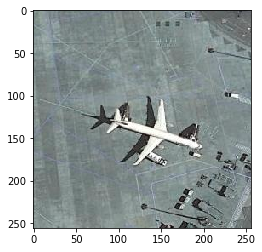

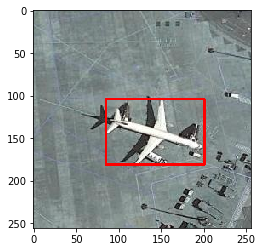

In [4]:
visualization()

### Using built selective search method

In [5]:
cv2.setUseOptimized(True);
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

239 221 17 35
225 13 25 16
0 0 95 194
111 113 23 29
174 0 62 75
199 125 49 67
48 71 53 36
0 168 63 74
176 185 24 34
0 0 95 251
48 71 97 94
90 128 33 12
9 168 57 71
39 168 21 20
71 76 29 33
201 150 23 23
86 245 19 11
150 245 16 11
111 113 25 51
26 221 20 25
246 239 10 17
0 209 83 47
41 210 40 23
201 9 24 42
90 128 32 12
89 116 31 11
227 13 23 16
0 0 96 251
72 129 20 33
73 208 22 48
205 124 35 17
54 76 82 89
240 223 16 33
72 133 21 30
0 186 82 70
108 114 25 13
245 239 11 17
205 85 44 54
188 85 68 129
217 85 30 31
187 85 69 129
200 54 20 11
122 139 14 29
201 46 20 8
48 77 88 91
55 174 45 62
22 218 10 35
65 115 16 44
72 128 50 35
51 102 23 10
55 174 45 82
150 246 16 10
187 123 23 25
201 150 23 25
222 0 14 18
72 133 22 30
48 76 86 75
242 226 14 30
88 116 36 25
174 9 57 65
29 210 76 46
156 244 24 12
8 0 248 256
201 46 28 26
26 220 24 26
7 189 31 34
50 76 86 89
179 24 37 18
174 0 62 74
88 120 36 21
0 190 96 66
55 0 177 157
150 85 106 171
174 9 68 65
0 209 82 47
169 85 87 171
171 10 60 68
54 7

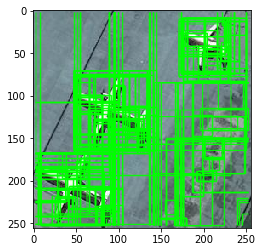

In [6]:
im = cv2.imread(os.path.join(path,"airplane_001.jpg"))
selective_search.setBaseImage(im)
selective_search.switchToSelectiveSearchFast()
rects = selective_search.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    print(x,y,w,h)
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [7]:
train_images=[]
train_labels=[]

### Intersection over union(IOU)
##### Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.

##### More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:
###### 1) The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
###### 2) The predicted bounding boxes from our model.


###### IoU = Area of  Overlap(intesection) / Area of Union(Union)

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [10]:
for e,i in enumerate(os.listdir(annotation)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotation,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_062.jpg
inside
1 airplane_028.jpg
2 airplane_094.jpg
3 airplane_024.jpg
4 airplane_032.jpg
5 airplane_022.jpg
6 airplane_100.jpg
7 airplane_041.jpg
inside
8 airplane_097.jpg
inside
9 airplane_036.jpg
10 airplane_099.jpg
11 airplane_018.jpg
12 airplane_072.jpg
13 airplane_043.jpg
14 airplane_057.jpg
15 airplane_079.jpg
16 airplane_058.jpg
17 airplane_083.jpg
inside
18 airplane_084.jpg
19 airplane_065.jpg
20 airplane_031.jpg
21 airplane_014.jpg
22 airplane_008.jpg
23 airplane_030.jpg
24 airplane_033.jpg
25 airplane_042.jpg
26 airplane_013.jpg
27 airplane_053.jpg
inside
28 airplane_087.jpg
29 airplane_050.jpg
30 airplane_044.jpg
31 airplane_092.jpg
32 airplane_004.jpg
inside
33 airplane_001.jpg
inside
34 airplane_039.jpg
35 airplane_038.jpg
36 airplane_003.jpg
37 airplane_009.jpg
38 airplane_011.jpg
39 airplane_080.jpg
40 airplane_016.jpg
41 airplane_098.jpg
42 airplane_078.jpg
43 airplane_077.jpg
44 airplane_066.jpg
45 airplane_049.jpg
46 airplane_046.jpg
47 airplane_068.jpg
4

In [11]:
x_train = np.array(train_images)
y_train = np.array(train_labels)

### VGG19 model

In [12]:
vgg = VGG19(weights='imagenet', include_top=True)

In [13]:
for layers in (vgg.layers)[:15]:
    print(layers)
    layers.trainable = False


In [14]:
X = vgg.layers[-2].output

In [15]:
predictions = Dense(2, activation="softmax")(X)

In [16]:
model = Model(inputs = vgg.input, outputs = predictions)
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
checkpoint = ModelCheckpoint("rcnn_vgg19_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [19]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [20]:
lenc = MyLabelBinarizer()
y_train =  lenc.fit_transform(y_train)

In [21]:
X_train, X_test , y_train, y_test = train_test_split(x_train,y_train,test_size=0.10)

In [22]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3971, 224, 224, 3) (442, 224, 224, 3) (3971, 2) (442, 2)


In [1]:
#hist = model.fit(X_train, y_train, epochs= 1000, validation_data= (X_test, y_test), validation_steps=2, callbacks=[checkpoint,early])